# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
import os
java_path = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path

#For NLP
import nltk
#nltk.internals.config_java('C:/Program Files/Java/jdk1.8.0_161/bin/java.exe') # fix my java problem

#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [2]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
..\stanford-NLP\parser already exists, skipping download
..\stanford-NLP\ner already exists, skipping download
..\stanford-NLP\postagger already exists, skipping download
..\stanford-NLP\core already exists, skipping download
[100%]Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [3]:
import lucem_illud.stanford as stanford

D:\computation\Anaconda3\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
D:\computation\Anaconda3\lib\site-packages\nltk\tag\stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [4]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [5]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [6]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)
print(redditDF)

                    author  over_18  score                subreddit  \
0         guitarsdontdance    False  14089  Tales From Tech Support   
1                   SECGaz    False  13724  Tales From Tech Support   
2        Clickity_clickity    False  13404  Tales From Tech Support   
3           TheDroolinFool    False  13152  Tales From Tech Support   
4              goldie-gold    False  12650  Tales From Tech Support   
5                  Raitaro    False  12372  Tales From Tech Support   
6                   sfsdfd    False  11295  Tales From Tech Support   
7                Bombadils    False  10528  Tales From Tech Support   
8           brenkelieshere    False   9448  Tales From Tech Support   
9                  CopperD    False   9359  Tales From Tech Support   
10       Theallmightyadmin    False   9293  Tales From Tech Support   
11                Sparkism    False   8772  Tales From Tech Support   
12             DallasITGuy    False   8702  Tales From Tech Support   
13    

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [7]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [8]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [9]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [10]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 ('time', 14),
 (')', 14),
 ('lot', 12),
 ('computer', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('message', 9),
 ('**Me**', 9),
 ('system', 9),
 ('day', 9),
 ('call', 8),
 ('laptop', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [11]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('tell', 6),
 ('send', 6),
 ('go', 5),
 ('work', 4),
 ('use', 4),
 ('receive', 4),
 ('thank', 4),
 ('feel', 4),
 ('want', 4),
 ('call', 4)]

What about the adjectives that modify the word, "computer"?

In [12]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [13]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [14]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [15]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [16]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [17]:
# load my corpus - 73 New York Times articles from the 1980s that discuss American POWs and the Vietnam War

powOnly = pandas.read_csv('../data/powOnly.csv')


In [18]:
# prep

powOnly['sentences'] = powOnly['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
powOnly['POS_sents'] = powOnly['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

Below, I first examine the distributions of **nouns**, **verbs**, and **adverbs**.

I then examine the conditional frequences of the *adjectives* modifying the words *war*, *vietnam*, and *prisoner*. 

One interesting finding from the frequencies is that *war* was often modified by *korea* - an (admitedly not altogether counterintuitive finding, and) indication that pow/mia issues stemming from the Vietnam War were often tied to Americans' experience of the Korean War.

In [19]:
# nouns

countTarget = 'NN'
targetCounts = {}
for entry in powOnly['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('issue', 141),
 ('war', 112),
 ('today', 93),
 ('action', 81),
 ('LANGUAGE', 73),
 ('ENGLISH', 56),
 ('official', 53),
 ('information', 51),
 ('delegation', 50),
 ('group', 49),
 ("''We", 46),
 ('meeting', 45),
 ('week', 35),
 ('director', 32),
 ('year', 32),
 ('time', 32),
 ('search', 28),
 ('aid', 28),
 ('month', 27),
 ('cooperation', 25)]

In [20]:
# verbs

countTarget = 'VB'
targetCounts = {}
for entry in powOnly['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 174),
 ('have', 45),
 ('resolve', 27),
 ('discuss', 24),
 ('know', 16),
 ('make', 16),
 ('like', 15),
 ('help', 14),
 ('visit', 12),
 ('deal', 12),
 ('take', 12),
 ('return', 12),
 ('get', 11),
 ('hold', 11),
 ('provide', 11),
 ('allow', 10),
 ('meet', 10),
 ('believe', 10),
 ('want', 10),
 ('find', 10)]

In [21]:
# adverbs

countTarget = 'RB'
targetCounts = {}
for entry in powOnly['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('not', 147),
 ('still', 109),
 ('also', 57),
 ("n't", 36),
 ('now', 36),
 ('here', 28),
 ('as', 24),
 ('even', 23),
 ('only', 20),
 ('very', 19),
 ('so', 17),
 ('ago', 17),
 ('far', 16),
 ('then', 16),
 ('well', 15),
 ('recently', 15),
 ('down', 14),
 ('there', 14),
 ('back', 12),
 ('never', 12)]

In [22]:
# adjectives modifying the word 'war'

NTarget = 'JJ'
Word = 'war'
NResults = set()
for entry in powOnly['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'Vietnamese', 'Korean', 'seven-year-old', 'divisive', 'American'}


In [23]:
# adjectives modifying the word 'vietnam'

NTarget = 'JJ'
Word = 'vietnam'
NResults = set()
for entry in powOnly['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'first', 'middleof-the-road', 'unified'}


In [24]:
# adjectives modifying the word 'prisoner'

NTarget = 'JJ'
Word = 'prisoner'
NResults = set()
for entry in powOnly['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'former', 'American'}


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [25]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [26]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [27]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [28]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [29]:
[x[0] for x in sortedEntities if x[1] == 2]

['year',
 'Desk',
 'busy',
 'fix',
 'received',
 'couple',
 'Windows',
 'anymore',
 'Sure',
 'error',
 'DVD',
 'opened',
 'There',
 'upside',
 'local',
 'bane',
 'existence',
 'learn',
 'sometimes',
 'generic',
 'Everyone',
 'login',
 'times',
 'guy',
 'asset',
 'name',
 'Computer',
 'nothing',
 "'P4ssword",
 'P',
 'Everything',
 'case',
 '*type',
 'S',
 'LOWERCASE',
 'used',
 'four',
 'Original',
 'cancer',
 'month',
 'live',
 'brave',
 'bitter',
 'passed',
 'ago',
 'absolutely',
 'ready',
 'proud',
 'above',
 'completely',
 'its',
 'meant',
 'both',
 'sharing',
 'making',
 '100',
 'share',
 'looking',
 'ALL',
 'whom',
 'business',
 'whose',
 'stronger',
 'bad',
 'mess',
 'turn',
 'first',
 'others',
 'Here',
 'suggested',
 'videos',
 'While',
 'stand',
 'certain',
 'enjoy',
 'well',
 'drowned',
 'soon',
 'understand',
 'risks',
 'myself',
 'point',
 'future',
 'avoid',
 'thinking',
 'information',
 'insurance',
 'site',
 'step',
 'guide',
 'discover',
 'order',
 '5',
 'slightly',
 's

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [30]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Citrix', 1),
 ('Nono', 1),
 ('Reddit', 1),
 ('Helpdesk', 1),
 ('UK', 1),
 ('CMD', 1)]

What about the Organizations?

In [31]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('Citrix', 1), ('Helpdesk', 1), ('CMD', 1), ('GOOGLE', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

For the purposes of my project, one of the most interesting frequencies is the tendency for the National League of Families to show up as a prominent *organization*. The National League was very involved in these issues and wielded power and influence disproportionate to its size and resources.

In [32]:
powOnly['classified_sents'] = powOnly['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [33]:
# entities

entityCounts = {}
for entry in powOnly['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('the', 2038),
 (',', 1878),
 ('.', 1533),
 ('of', 1224),
 ('to', 975),
 ('in', 856),
 ('and', 645),
 ('a', 596),
 ('that', 545),
 ("''", 454)]

In [34]:
[x[0] for x in sortedEntities if x[1] == 2]

['tension',
 'fruitless',
 'resumed',
 'Oct.',
 'trick',
 'deceive',
 'opinion',
 'bent',
 'aggression',
 'slightest',
 'sincerity',
 'negotiated',
 'urged',
 'assist',
 'Such',
 "''logistical",
 'claim',
 'handed',
 'finding',
 'parties',
 'Interested',
 "''Why",
 'Why',
 'build',
 'type',
 'remove',
 'Tom',
 'infantryman',
 'range',
 'gaze',
 'streets',
 'rhetoric',
 'disturbed',
 'pretty',
 "''What",
 '22',
 'basis',
 'activity',
 'welcomed',
 'victory',
 'Nixon',
 'crippled',
 'sprayed',
 'cause',
 'suggestion',
 'assess',
 'connection',
 'affected',
 'visas',
 'investigators',
 'assured',
 'main',
 'feelings',
 'anger',
 'guilt',
 'fear',
 'stopped',
 'wreckage',
 'Frank',
 'Our',
 'tears',
 'MIG',
 'upset',
 'serve',
 'liaison',
 'missing-inaction',
 'doctors',
 'health',
 'bad',
 'publicity',
 'G.I',
 'becoming',
 'add',
 'endorsed',
 'resisted',
 'inquiries',
 'urgent',
 'caused',
 'wider',
 'delusion',
 'Who',
 'flag',
 'above',
 'front',
 'crowded',
 'documents',
 'Central',


In [35]:
# persons

PersonCounts = {}
for entry in powOnly['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in PersonCounts:
                PersonCounts[ent] += 1
            else:
                PersonCounts[ent] = 1
sortedPersons = sorted(PersonCounts.items(), key = lambda x: x[1], reverse = True)
sortedPersons[:10]

[('Reagan', 69),
 ('Shultz', 42),
 ('Thach', 41),
 ('Vessey', 37),
 ('Armitage', 33),
 ('Richard', 29),
 ('Nguyen', 28),
 ('Muller', 24),
 ('Griffiths', 23),
 ('John', 21)]

In [36]:
# locations

LocationCounts = {}
for entry in powOnly['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'LOCATION':
                continue
            elif ent in LocationCounts:
                LocationCounts[ent] += 1
            else:
                LocationCounts[ent] = 1
sortedLoc = sorted(LocationCounts.items(), key = lambda x: x[1], reverse = True)
sortedLoc[:10]

[('Vietnam', 351),
 ('Hanoi', 240),
 ('United', 224),
 ('States', 223),
 ('Laos', 87),
 ('Washington', 74),
 ('Cambodia', 60),
 ('Indochina', 49),
 ('Asia', 47),
 ('Southeast', 43)]

In [37]:
# organizations

OrgCounts = {}
for entry in powOnly['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('of', 73),
 ('Department', 59),
 ('State', 58),
 ('Defense', 42),
 ('National', 36),
 ('League', 27),
 ('United', 24),
 ('Families', 22),
 ('American', 20),
 ('Air', 19)]

Below, I'll compare the NER coding against my own hand coding using precision, recall, and F1 scores. For this portion of the exercise, I'm only interested in coding **'organizations'**.

For practicality's sake, I've pseudo-randomly selected one article to hand code. If I were to extend this approach for a full project, I would probably certainly use a better (and more properly random) selection of documents for 'testing.'

Again, for practicality's sake, I handcode only the first six sentences from this article. 

In [38]:
# save my sample

display(powOnly['article'][60])

sample = powOnly['classified_sents'][60]
sample = sample[:6]

"      Secretary of State George P. Shultz confirmed today that Vietnam had relented and agreed to American conditions for a meeting with a special envoy to discuss the issue of missing servicemen.  But Mr. Shultz, speaking at the annual meeting of the National League of Families of American Prisoners and Missing in Southeast Asia, also warned that there might not be much progress on the issue. He said it was good that Vietnam no longer insisted that discussions on missing servicemen be linked with the issue of normalizing relations.  ''We are pleased that the Vietnamese Government has accepted our proposal for a visit by a Presidential emissary on P.O.W. and M.I.A. and other humanitarian issues,'' he said. ''We are also pleased that Hanoi has confirmed that the two sides should not link these humanitarian issues with any outstanding political problem between our two countries.''  Earlier this month a Vietnamese official said Hanoi had sent American negotiators a letter dropping many p

In [111]:
# the above sample was saved as a csv, then hand coded.

codedSample = pandas.read_csv(r'C:\Users\Alex\contentAnalysis\content-analysis-2018\7-Information-Extraction\codedSample.csv', encoding = 'ANSI')

In [117]:
display(codedSample[:5])

,entity,machineCodeOrganization,handCodeOrganization
0,"('Secretary', 'O')",False,False
1,"('of', 'O')",False,False
2,"('State', 'ORGANIZATION')",True,False
3,"('George', 'PERSON')",False,False
4,"('P.', 'PERSON')",False,False


As we can see, the machine coding doesn't quite perform up to the standards of an expert coder. BUT this is very, very small sample that cannot tell us how this would perform on a larger set of documents.

In [114]:
import sklearn

In [118]:
# precision

sklearn.metrics.precision_score(codedSample['machineCodeOrganization'], codedSample['handCodeOrganization'])

0.5833333333333334

In [122]:
# recall

sklearn.metrics.recall_score(codedSample['machineCodeOrganization'], codedSample['handCodeOrganization'])

0.875

In [121]:
# f1 

sklearn.metrics.f1_score(codedSample['machineCodeOrganization'], codedSample['handCodeOrganization'])

0.7000000000000001

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [40]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [41]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [42]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [43]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [44]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [45]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [46]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [47]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x0000023140B2B9D8>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
               

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

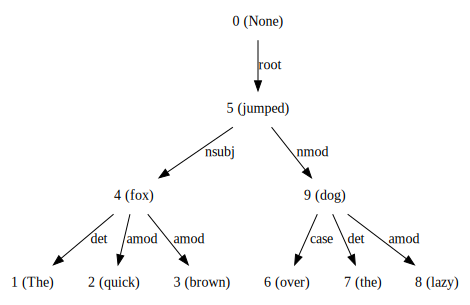

In [48]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

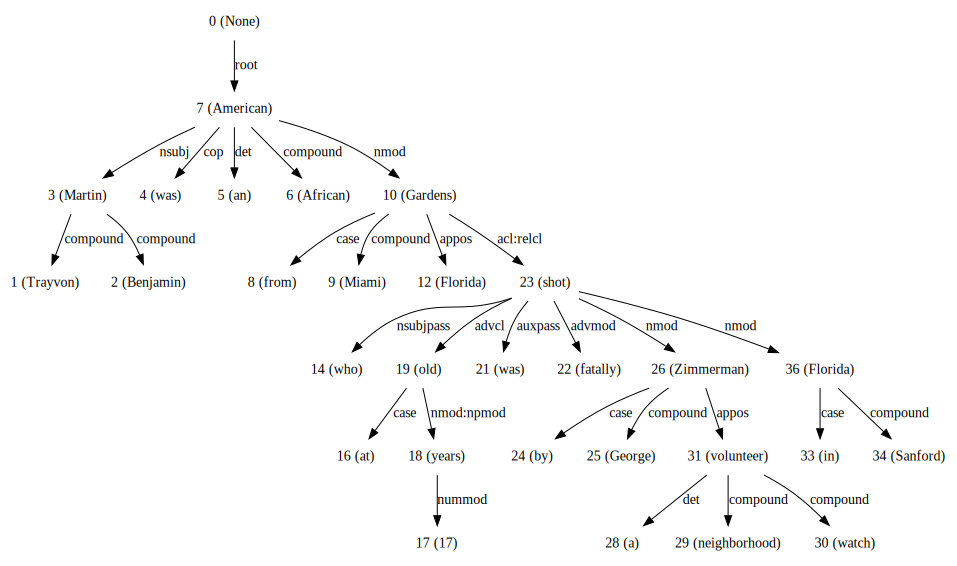

In [49]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [50]:
display(redditTopScores['sentences'])

9    [[Last, year, ,, Help, Desk, got, a, call, fro...
8    [[First, post, in, quite, some, time, !], [I, ...
7    [[[, Original, Post, ], (, https, :, //www.red...
6    [[I, witnessed, this, astounding, IT, meltdown...
5    [[I, work, Helpdesk, for, a, retail, store, ch...
4    [[This, just, happened, ...], [So, ,, I, had, ...
3    [[Another, tale, from, the, out, of, hours, IT...
2    [[[, Part, 1, ], (, http, :, //www.reddit.com/...
1    [[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -...
0    [[So, my, story, starts, on, what, was, a, nor...
Name: sentences, dtype: object

In [51]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [52]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

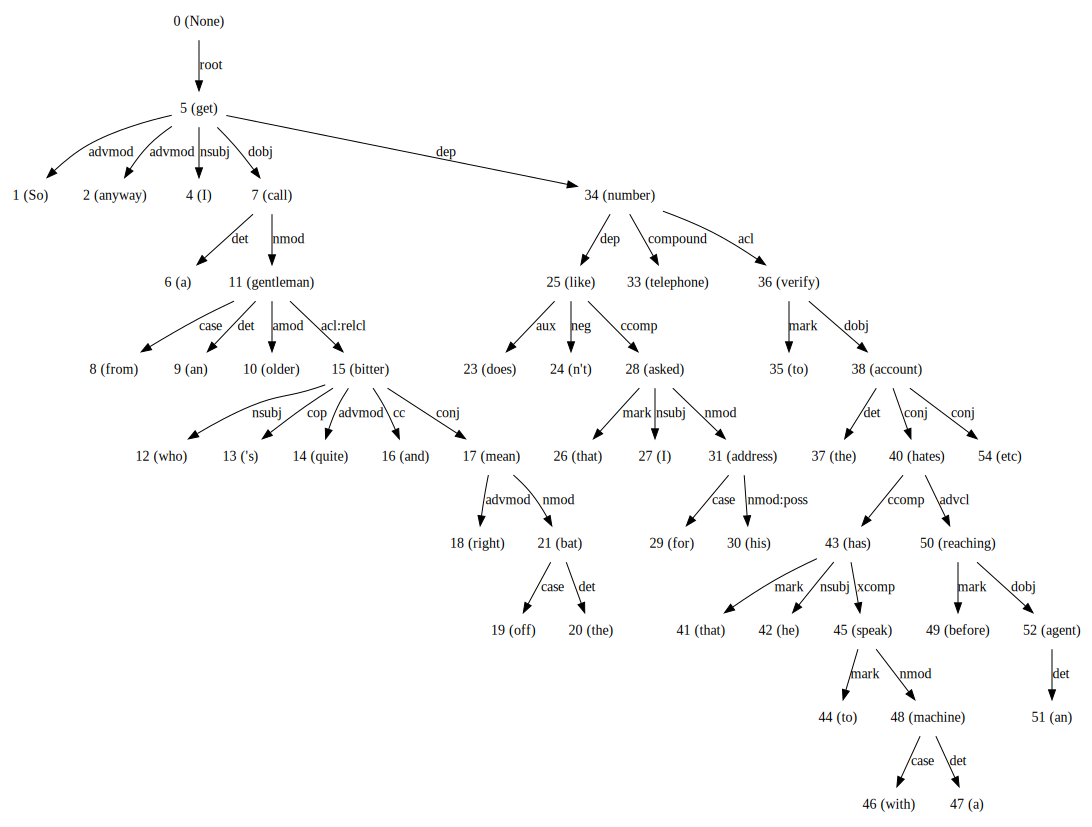

In [53]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

For this exercise, I'm going to select a single article - one published in January of 1986.

In [54]:
print(powOnly['article'][45])

   , Thailand, Jan. 12   While American and Vietnamese officials expressed satisfaction last week with the atmosphere of good will surrounding two days of high-level talks in Hanoi on Americans missing in action since the Vietnam War, both sides agreed that they had reached a time when building confidence and increasing cooperation would be critical.  Material progress will have to be made, they said, if the issue of the missing is no longer to prevent better relations between the two countries.  There are potential problems on both sides, officials said, and the wide attention paid to the negotiations, which produced no breakthroughs, could sharpen divisions.  Wants U.S. to 'Leave Us Alone'  Not all Vietnamese leaders favor cooperation with the United States.  Asked by reporters last Monday what he most wanted from Washington, Vo Dong Giang, the second-highest ranking official in the Vietnamese Foreign Ministry, said, ''We would like the U.S. to leave us alone and stop assisting China

In [55]:
exArticle = powOnly.ix[45]

First, let's parse and then look at some trees.

In [56]:
parses = list(stanford.parser.parse_sents(exArticle['sentences']))
firstSentParseTree = list(parses[0]) #iterators so be careful about re-running code, without re-running this block
print(firstSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('FRAG', [Tree(',', [',']), Tree('NP', [Tree('NNP', ['Thailand'])])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Jan.']), Tree('CD', ['12'])]), Tree('SBAR', [Tree('IN', ['While']), Tree('S', [Tree('NP', [Tree('JJ', ['American']), Tree('CC', ['and']), Tree('JJ', ['Vietnamese']), Tree('NNS', ['officials'])]), Tree('VP', [Tree('VBD', ['expressed']), Tree('NP', [Tree('NN', ['satisfaction'])]), Tree('NP', [Tree('JJ', ['last']), Tree('NN', ['week'])]), Tree('PP', [Tree('IN', ['with']), Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('NN', ['atmosphere'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('JJ', ['good']), Tree('NN', ['will'])])])])]), Tree('S', [Tree('VP', [Tree('VBG', ['surrounding']), Tree('NP', [Tree('NP', [Tree('CD', ['two']), Tree('NNS', ['days'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('JJ', ['high-level']), Tree('NNS', ['talks'])])])]), Tree('PP', [Tree('IN', ['in']), Tree('NP', [Tree('NNP', ['Hanoi'])])]), Tree('PP', [Tre

Based on what we see below, it seems to be the case that parse depth increases with sentence complexity.

In [57]:
firstSentParseTree[0].pretty_print()

                                                                                                                                                                                                                          ROOT                                                                                                                                                                                                                 
                                                                                                                                                                                                                           |                                                                                                                                                                                                                    
                                                                                                                                       

In [58]:
list(parses[1])[0].pretty_print()

                                                                                     ROOT                                                                                                  
                                                                                      |                                                                                                     
                                                                                      S                                                                                                    
           ___________________________________________________________________________|__________________________________________________________________________________________________   
          |                 VP                                                                                                                                                           | 
          |             ____|____                         

Now, I'll dependency parse.

In [59]:
print(exArticle)

article                , Thailand, Jan. 12   While American and Vi...
date                                                 January 12 1986 
cluster                                                             2
sentences           [[,, Thailand, ,, Jan., 12, While, American, a...
POS_sents           [[(,, ,), (Thailand, NNP), (,, ,), (Jan., NNP)...
classified_sents    [[(,, O), (Thailand, LOCATION), (,, O), (Jan.,...
Name: 45, dtype: object


In [60]:
powDepParse = list(stanford.depParser.parse_sents(exArticle['sentences']))

In [61]:
targetSentence = 0
print(' '.join(exArticle['sentences'][targetSentence]))

, Thailand , Jan. 12 While American and Vietnamese officials expressed satisfaction last week with the atmosphere of good will surrounding two days of high-level talks in Hanoi on Americans missing in action since the Vietnam War , both sides agreed that they had reached a time when building confidence and increasing cooperation would be critical .


A long, multi-clause sentence gives us a deep tree:


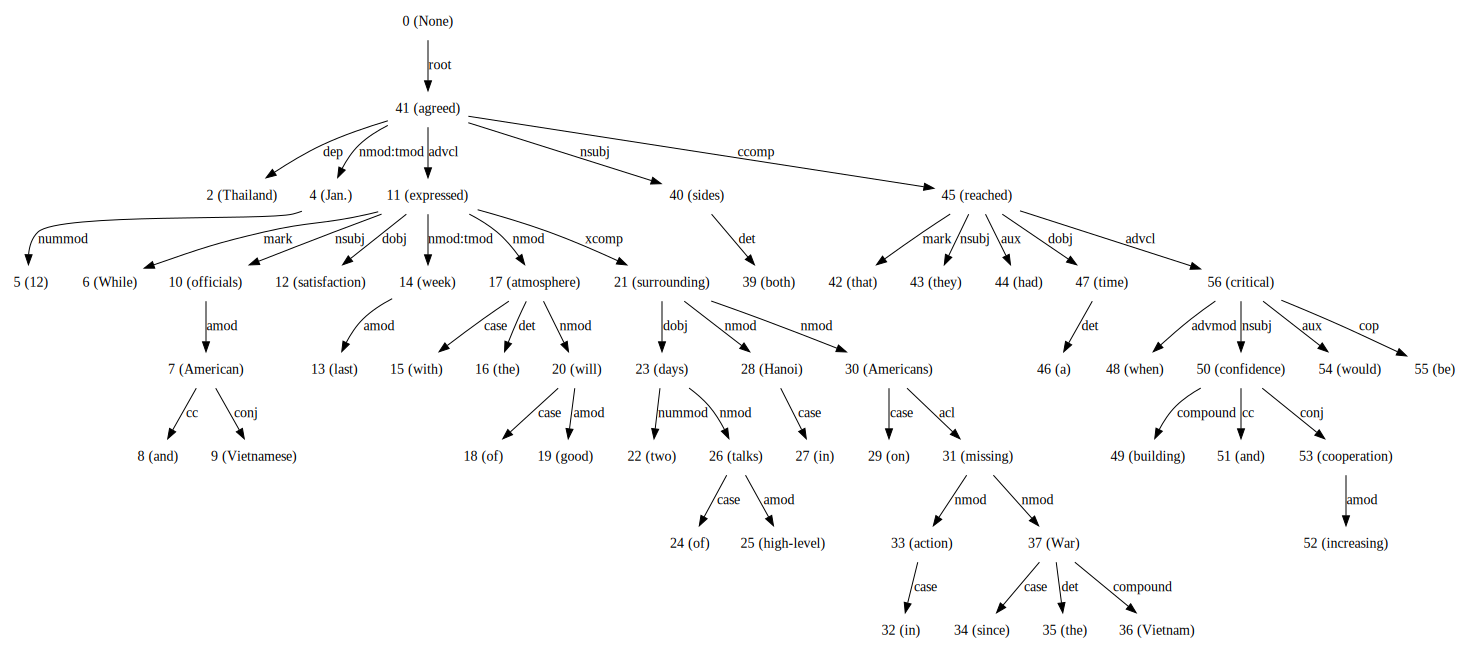

In [62]:
print('A long, multi-clause sentence gives us a deep tree:')

try:
    graph = graphviz.Source(list(powDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

In [63]:
targetSentence = 1
print(' '.join(exArticle['sentences'][targetSentence]))

Material progress will have to be made , they said , if the issue of the missing is no longer to prevent better relations between the two countries .


Shorter sentence, but also a deep tree:


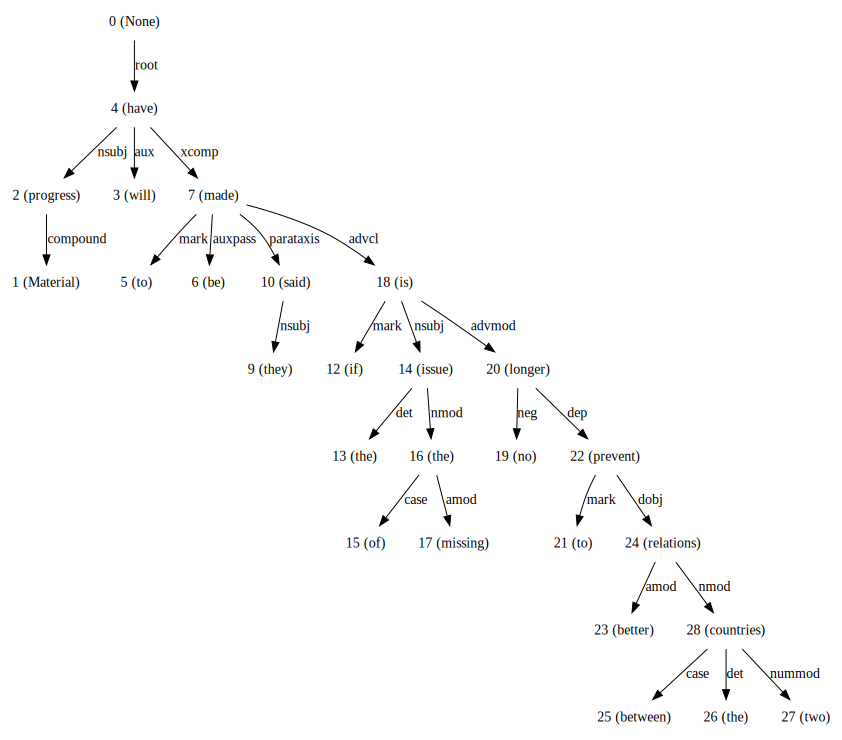

In [64]:
print('Shorter sentence, but also a deep tree:')

try:
    graph = graphviz.Source(list(powDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

In [65]:
targetSentence = 7
print(' '.join(exArticle['sentences'][targetSentence]))

Anti-American language has been absent from public pronouncements .


A short, simple sentence gives us a short, stubby tree:


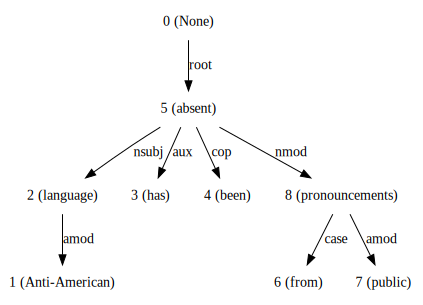

In [66]:
print('A short, simple sentence gives us a short, stubby tree:')

try:
    graph = graphviz.Source(list(powDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

Now, I'll extract five interesting pieces of information through parsing. Let's take the very first sentence and start by looking at noun phrases and 'Vietnam.'

In [67]:
treeRelation(firstSentParseTree, 'NP', 'Vietnam')

[[('NP', 'Americans missing in action since the Vietnam War')],
 [('NP', 'the Vietnam War')]]

In [126]:
treeSubRelation(firstSentParseTree, 'VB', 'Vietnam')

set()

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [69]:
ieDF = stanford.startCoreServer(text)

Starting server on http://localhost:['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo'] , please wait a few seconds
click Kernel -> Then Interupt to stop         (･ω･｀)))                
Exiting (ノ≧▽≦)ノ


`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [70]:
ieDF

No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In looking through the dependency parse produced with stanfordNLP, I was drawn to the verb *shot* and its centrality.

One path 'out' or 'away' from *shot* on the **enhanced++ dependencies** tree leads to *Gardens*, the location of the murder. The fact that there is no such corresponding dependency link between *shot* and *Trayvon Benjamin Martin* might lead one to ask whether US news coverage of urban violence generally favors reporting **locations** rather than **persons**.

This approach could be applied to my own project by mapping changes in dependencies over time. For example, what kinds of verbs are central and with what kinds of entities do they share dependency in one period vs. another. To be more specific, it might be the case that the National League of Families is a more important entity in one period, whereas the Vietnamese government itself might be more important in another. 

In [4]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds
click Kernel -> Then Interupt to stop    (((っ･д･)っ                    
Exiting (ノ≧▽≦)ノ


And we can also look for subject, object, target triples in one of the reddit stories.

In [73]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
Error: Could not find or load main class edu.stanford.nlp.naturalli.OpenIE



In [74]:
ieDF

,certainty,subject,verb,object


That's almost 200 triples in only:

In [75]:
len(redditTopScores['sentences'][0])

37

sentences and

In [76]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [77]:
ieDF['subject'].value_counts()

Series([], Name: subject, dtype: int64)

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [78]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

Series([], Name: verb, dtype: int64)

and the following objects

In [79]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Series([], Name: object, dtype: int64)

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [102]:
stanford.startCoreServer()

Starting server on http://localhost:16432 , please wait a few seconds
click Kernel -> Then Interupt to stop         (((っ･д･)っ               
Exiting (ノ≧▽≦)ノ


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.

In [5]:
ieDF = stanford.openIE(text)

Starting OpenIE run
Error: Could not find or load main class edu.stanford.nlp.naturalli.OpenIE



In [ ]:
exDF = stanford.openIE(exArticle['article'])

In [ ]:
exDF

In [ ]:
len(exDF['sentences'])

In [ ]:
sum([len(s) for s in exDF['sentences']])

In [ ]:
exDF['subject'].value_counts()

In [ ]:
exDF[exDF['subject'] == 'INSERT SUBJECT FROM ABOVE HERE']['verb'].value_counts()

In [ ]:
exDF[exDF['subject'] == 'INSERT SAME SUBJECT HERE']['object'].value_counts()